In [54]:
import numpy as np 
import pandas as pd 
import torch 
from matplotlib import pyplot as plt 
import seaborn as sbn
import pickle as pkl
import pandas as pd

import model as gcn
import config
import utils
from mish import Mish

import time
import sys
import os

from IPython.display import clear_output, display

import networkx as nx

## Performance

We will compare model correllation and MSE values for: 

1. `test` partition: **Cell Lines** that were never trained on (unique genomes)
2. `holdout_genes` : **Genes** that were never trained on (unique adjacency matrices)

To show that out model can learn in this topology based framework. 

## Interpretation 

To interpret our model, we can: 

1. Take a look at the learned GCN layers (since we're mapping 1 dim -> 1 dim) 
2. Take a look at our learned coupling matrix (edge weights); visualize as graph


## Application Example

To further explore how a model like this can be used to answer interesting questions, we can predict gene dependency for some key genes with known cancer vulnerabilities. 
Additionally, we can look at the activations of our network:  

1. which genes are activated?   
2. which pathways are activated?   

Can we simulate multi-gene KO and see gene dependency change?   



In [2]:
STATE_DICT_PATH = '../pretrained_weights/model_state_dict-EPOCH_99.pkl'

# Model Performance 

## Load test partitions

In [3]:
print('loading data generators ... ')
with open(f'{config.DATA_PATH}partition_dict.pkl', 'rb') as f:
    partition = pkl.load(f)

with open(f'{config.DATA_PATH}label_dict.pkl', 'rb') as f:
    labels = pkl.load(f)

print('partitions: ')
print('  '.join(list(partition.keys())))


loading data generators ... 
partitions: 
train  test  val  holdout_genes


In [4]:
params = {
          'batch_size'   :    10,
          'shuffle'      :    False,
          'num_workers'  :    0
          }

# Generators
test_set = utils.Dependency_Dataset(partition['test'], labels)
test_gen = torch.utils.data.DataLoader(test_set, **params)
print('size of test set:', len(test_set))

holdout_set = utils.Dependency_Dataset(partition['holdout_genes'], labels)
holdout_gen = torch.utils.data.DataLoader(holdout_set, **params)
print('size of test [ hold out genes ] set:', len(holdout_set))

size of test set: 105560
size of test [ hold out genes ] set: 31050


## load model

In [5]:
nnodes = test_set.ADJ.size()[0]
print('number of nodes in graph:', nnodes)

#! CUDA info
cuda_available = torch.cuda.is_available()
print('cuda is available:', cuda_available)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

print('loading GO-term matrix...')
GO_matrix = torch.load(config.GO_MATRIX_PATH)
GO_matrix = GO_matrix.to(device)

# Model and optimizer
model = gcn.TORTOISE_GCN(nnodes=nnodes, nfeat=1, GO_mat=GO_matrix)

print( 'loading trained model weights' )
model.load_my_state_dict(STATE_DICT_PATH)

model.to(device)

number of nodes in graph: 1076
cuda is available: False
device: cpu
loading GO-term matrix...
loading trained model weights
using pretrained weights...
	C: Updated
	out1: Updated
	out1_bias: Updated
	out2: Updated
	gc1.W: Updated
	gc1.B: Updated
	gc2.W: Updated
	gc2.B: Updated
	gc3.W: Updated
	gc3.B: Updated
	gc4.W: Updated
	gc4.B: Updated


TORTOISE_GCN(
  (gc1): GraphConvolution (1 -> 50)
  (gc2): GraphConvolution (50 -> 50)
  (gc3): GraphConvolution (50 -> 10)
  (gc4): GraphConvolution (10 -> 1)
)

## predict `test` (holdout cell lines)

Since we don't have a GPU on my local machine this is kind of slow, so we'll just predict a subset: adjust `npredict` for more. 

In [6]:
npredict = 500

def predict_dataset(model, data_generator, npredict):
        loss_function = torch.nn.MSELoss()
        model.eval()
        tic = time.time()
        _loss = [] ; i = 0 ; tic = time.time() ; ys = [] ; yhats = []; first=True
        for A, X, y in data_generator:
                clear_output(wait=True)
                if first: tic2 = time.time(); first = False
                A, X, y = A.to(device), X.to(device), y.to(device)
                i += X.size(0)
                output, gene_activations, pathway_activations = model(X, A, return_activations=True)
                ys += y.detach().cpu().numpy().ravel().tolist()
                yhats += output.detach().cpu().numpy().ravel().tolist()
                # record activations here 
                loss = loss_function(output, y)
                _loss += loss.detach().cpu().numpy().ravel().tolist()
                print(f'test progress: {i/len(test_gen.dataset)*100:.2f}% [{i}] --- batch loss: {loss:.4f} [avg time / obs: {1000*(time.time()-tic2)/i:.4f}ms  -- (init: {(tic2-tic):.2f}s)]\t\t\t', end='\r')
                sys.stdout.flush()
                if i >= npredict: break
        return (ys, yhats, _loss, i)

test_res = predict_dataset(model, test_gen, npredict)

# plot `test` 

test dataset correlation: 0.8485204460228084
test dataset average MSE: 0.00965526445955038


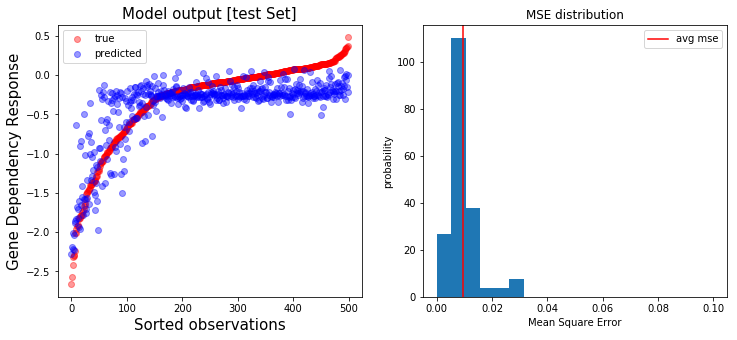

In [320]:
def plot_performance(ys, yhats, loss, i, dataset): 
    cor = np.corrcoef(ys, yhats)
    print('test dataset correlation:', cor[0,1])
    print('test dataset average MSE:', np.sum(loss)/i)

    fig, axes = plt.subplots(1,2, figsize = (12,5))

    ######### TRAIN #########
    alpha_ = 200./len(ys) if len(ys) > 200. else 1.

    df = pd.DataFrame({'y':ys, 'yhat':yhats})
    df.sort_values(by='y', inplace=True)

    axes[0].plot(df.values[:,0], 'ro', label='true', alpha=alpha_)
    axes[0].plot(df.values[:,1], 'bo', label='predicted', alpha=alpha_)

    axes[0].set_title(f'Model output [{dataset} Set]', fontsize=15)
    axes[0].set_xlabel('Sorted observations', fontsize=15)
    axes[0].set_ylabel('Gene Dependency Response', fontsize=15)
    axes[0].legend()

    axes[1].set_title('MSE distribution')
    axes[1].hist(np.array(loss)/(i/len(loss)), density=True, bins=np.linspace(0,.1,20))
    axes[1].axvline(x=np.sum(loss)/i, c='r', label='avg mse')
    axes[1].set_xlabel('Mean Square Error')
    axes[1].set_ylabel('probability')
    axes[1].legend()
    plt.show()

plot_performance(*test_res, dataset='test')

## predict `holdout genes` (unseen adjacency matrices)

In [321]:
gene_holdout = predict_dataset(model, holdout_gen, npredict)

## plot `holdout genes`

test dataset correlation: 0.8810536410993864
test dataset average MSE: 0.008976886965334415


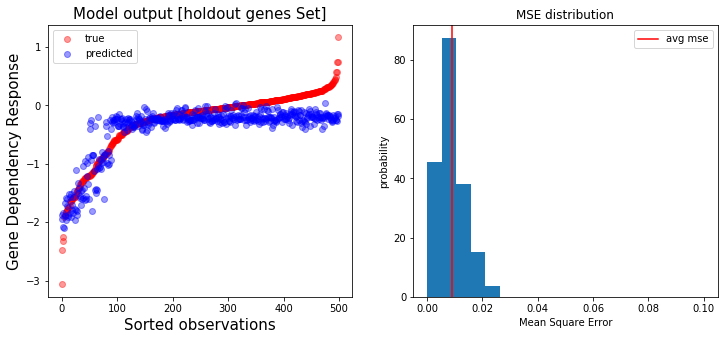

In [322]:
plot_performance(*gene_holdout, dataset='holdout genes')

# Model Interpretation 

## First, take a look at the GCN layer activation 


In [10]:
with open(STATE_DICT_PATH, 'rb') as f: 
    state_dict = pkl.load(f)

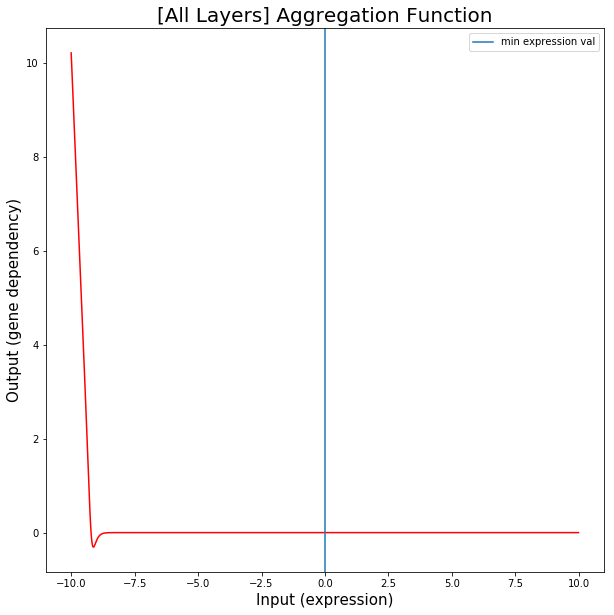

In [11]:
activation = Mish()

f, axes = plt.subplots(1,1,figsize=(10,10))

x = torch.Tensor( np.arange(-10,10, 0.01).reshape(-1,1) )

yy = activation( torch.mm( x, state_dict['gc1.W'] ) + state_dict['gc1.B'].T )
yy = activation( torch.mm( yy, state_dict['gc2.W'] ) + state_dict['gc2.B'].T )
yy = activation( torch.mm( yy, state_dict['gc3.W'] ) + state_dict['gc3.B'].T )
yy = activation( torch.mm( yy, state_dict['gc4.W'] ) + state_dict['gc4.B'].T )

plt.plot(x,yy,'r-')
plt.xlabel('Input (expression)', fontsize=15)
plt.ylabel('Output (gene dependency)', fontsize=15)
plt.title('[All Layers] Aggregation Function', fontsize=20)
plt.axvline(x=0, label='min expression val')
plt.legend()
plt.show()

# Visualize Learned Edge Weights; "Coupling" matrix 

We'll represent:  

1. pathways as `node color`  
2. self-weight as `node size`  
3. edge-weight as `edge size`  


In [12]:
with open('../data/MAPK-gene_order.pkl', 'rb') as f: 
    gene_order = pkl.load(f)

rev_order = {gene_order[g]:g for g in gene_order}

In [13]:
adj = torch.load('../data/MAPK-adjacency_matrix.pt').numpy()
print('adjacency size:', adj.shape)

C = state_dict['C'].numpy()

AC = adj*C 

adjacency size: (1076, 1076)


In [14]:
G = nx.from_numpy_matrix(AC)
print('number of nodes:', len(G))
print(f'number of edges [expect: {np.sum(np.triu(adj))}]:', len(G.edges))

number of nodes: 1076
number of edges [expect: 31038.0]: 31038


In [15]:
_pos = nx.drawing.layout.spring_layout(G, k=10/(np.sqrt(len(G))))
edge_width_ = [G[u][v]['weight'] for u,v in G.edges()]
_cmap = plt.cm.RdYlBu

# Load GO `biological processes` 


Unnamed: 0	id	uniprotKB	name	def	Gene_Name  
6586	6586	GO:0000165	Q02750	MAPK cascade	"An intracellular protein kinase cascade conta...	MAP2K1  
6587	6587	GO:0000187	Q02750	activation of MAPK activity	"The initiation of the activity of the inactiv...	MAP2K1  
6588	6588	GO:0000186	Q02750	activation of MAPKK activity	"The initiation of the activity of the inactiv...	MAP2K1  

In [16]:
GO = pd.read_csv('../data/final_GO_info.csv')
GO = GO[GO.Gene_Name.isin(gene_order.keys())]              # keep only genes in our network

mapk_genes = GO[GO.id == 'GO:0000165'].Gene_Name.unique()
print('number of mapk cascade genes:', len(mapk_genes))
GO.head()

number of mapk cascade genes: 198


,Unnamed: 0,id,uniprotKB,name,def,Gene_Name
42,42,GO:0006898,P07900,receptor-mediated endocytosis,"""An endocytosis process in which cell surface ...",HSP90AA1
43,43,GO:0038096,P07900,Fc-gamma receptor signaling pathway involved i...,"""An Fc-gamma receptor signaling pathway that c...",HSP90AA1
44,44,GO:1900034,P07900,regulation of cellular response to heat,"""Any process that modulates the frequency, rat...",HSP90AA1
45,45,GO:0000086,P07900,G2/M transition of mitotic cell cycle,"""The mitotic cell cycle transition by which a ...",HSP90AA1
46,46,GO:0000236,P07900,mitotic prometaphase,"""The cell cycle phase in higher eukaryotes whi...",HSP90AA1


In [17]:
_mapk_nodes = [gene_order[g] for g in mapk_genes]
alpha_ = np.abs(np.array(edge_width_))
alpha_ *= (.999 / alpha_.max())
edge_color_ = ['r' if G[u][v]['weight'] < 0 else 'b' for u,v in G.edges()]
node_size_ = [np.abs(G[u][u]['weight']) for u,v in G.edges()]

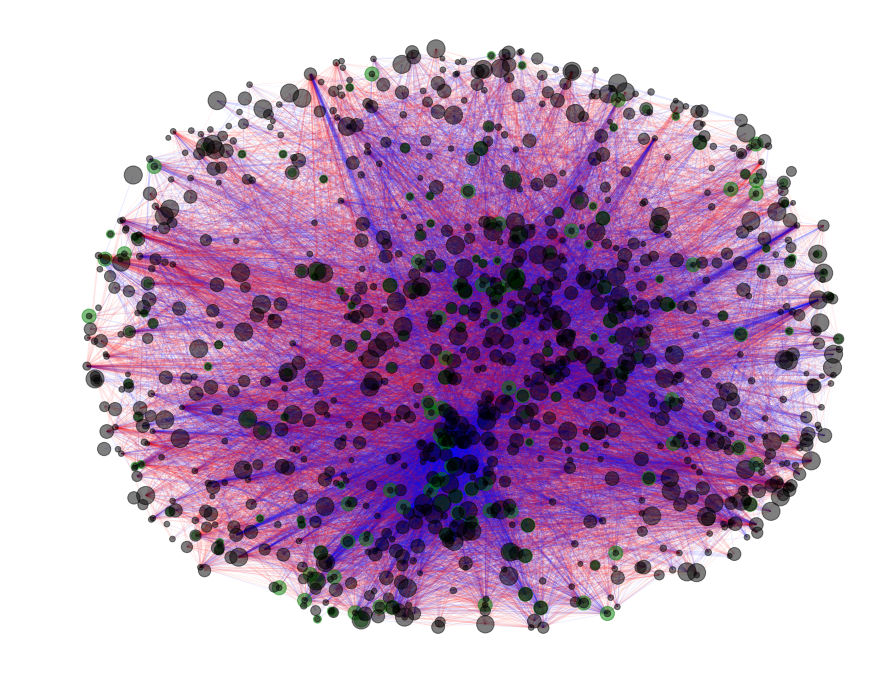

In [18]:
f, ax = plt.subplots(1,1,figsize=(15,12))

#nx.draw_networkx_labels(G, _pos, labels=rev_order, ax=ax)
#nx.draw_networkx_nodes(G, pos=_pos, node_size=100, node_color=np.diag(AC), cmap=_cmap, ax=ax)
#nx.draw_networkx_edges(G, pos=_pos, width=np.array(edge_color_), edge_color=edge_color_, alpha=0.5, edge_cmap=_cmap, ax=ax)

nx.draw_networkx_nodes(G, pos=_pos, nodelist = _mapk_nodes, node_size=200*np.array(node_size_), alpha=0.5, node_color='g', ax=ax)
nx.draw_networkx_nodes(G, pos=_pos, node_size=100*np.array(node_size_), alpha=0.5, node_color='k', ax=ax)
nx.draw_networkx_edges(G, pos=_pos, width=10*alpha_, edge_color=edge_color_, alpha=0.1, ax=ax)

#sm = plt.cm.ScalarMappable(cmap=_cmap, norm=plt.Normalize(vmin=np.min(AC), vmax=np.max(AC)))
#sm._A = []
#cbar = plt.colorbar(sm, )
#cbar.ax.set_ylabel("Gene Self Edge Weight", rotation=-90, va="bottom", fontsize=20)

plt.gca().axison = False
plt.show()

# If we group [and sum] self-edge weights by pathway, how do the pathways compare?

In [61]:
GO_mat = torch.load('../data/MAPK&overlap_pathway_matrix.pt').numpy()
print('size of GO matrix:', GO_mat.shape)

with open('../data/GO_pathway_order.pkl', 'rb') as f: 
    GO_order = pkl.load(f)
    
rev_GO_order = {GO_order[go]:go for go in GO_order}
GO_order_ls = [rev_GO_order[i] for i in range(len(GO_order))]

size of GO matrix: (1076, 27)


In [488]:
selfedge_pathway_activation = np.diag(AC) @ GO_mat
df = {'selfedge_activation':selfedge_pathway_activation}
df = pd.DataFrame(df)
df = df.assign(id = GO_order_ls)
df = df.merge(GO[['id','name','def']].drop_duplicates(), on='id', how='left')
df = df.sort_values(by='selfedge_activation', ascending=False).reset_index(drop=True)

df.head()

,selfedge_activation,id,name,def
0,1.327330,GO:0008543,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ..."
1,1.114263,GO:0019221,cytokine-mediated signaling pathway,"""A series of molecular signals initiated by th..."
2,0.732406,GO:0050852,T cell receptor signaling pathway,"""A series of molecular signals initiated by th..."
3,0.713055,GO:0038095,Fc-epsilon receptor signaling pathway,"""A series of molecular signals initiated by th..."
4,0.709036,GO:0002223,stimulatory C-type lectin receptor signaling p...,"""Any series of molecular signals generated as ..."


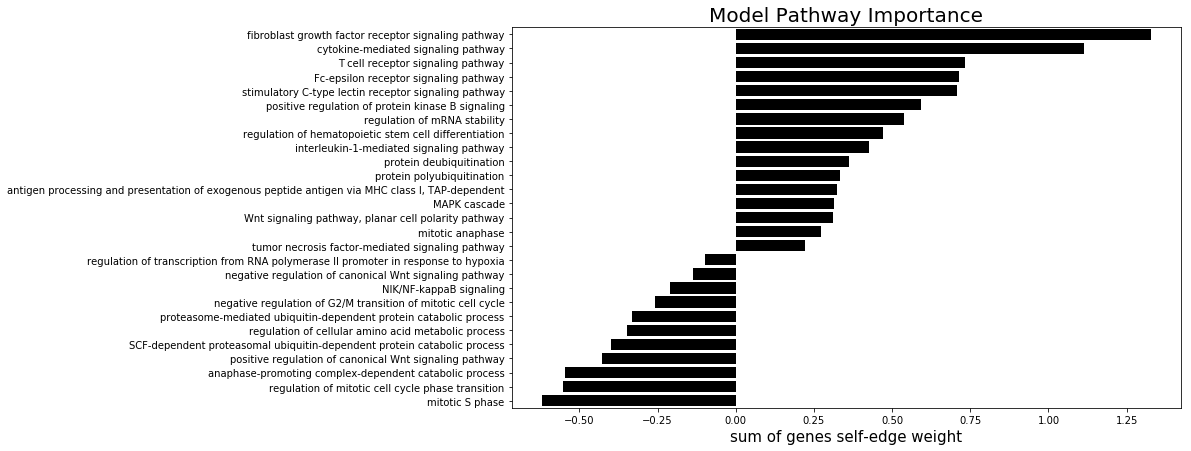

In [63]:
plt.figure(figsize=(12,7))
sbn.barplot(y='name', x='selfedge_activation', color='k', data=df, orient='h')
#plt.xticks(rotation=90)
plt.xlabel('sum of genes self-edge weight', fontsize=15)
plt.ylabel('')
plt.title('Model Pathway Importance', fontsize=20)
plt.show()

# Application: Predicting drug target KO 

We will try to answer the question: 

> Which drug target of imatinib is more important for reduced proliferation in cancer genomes? 

Trematinib is a cancer drug and a `MEK inhibitor`, specifically, it targets `MAP2K1/MEK1` and `MAP2K2/MEK2`.

For all the cancer genomes that we have access to (`cell lines`), we will predict the `gene dependency` response of knocking out:  

1. `MAP2K1`   
2. `MAP2K2`   
3. `MAP2K2` *and* `MAP2K1`  

In [79]:
class make_KOs: 
    
    def __init__(self): 
        self.ADJ = torch.load(config.ADJ_PATH)
        
        with open(config.GENEORDER_PATH, 'rb') as f:
            self.gene_order = pkl.load(f)

        
    def get_data(self, cell_line, KO):
        '''

        '''
        EXPR = torch.reshape(torch.load(f'{config.EXPR_PATH}{cell_line}.pt'), (self.ADJ.size(0), 1)).clone().detach().type(torch.float32).requires_grad_(False)
        A = self.ADJ.clone().detach().type(torch.float32).requires_grad_(False)
        
        for target in KO: 
            A[:, self.gene_order[target]] = 0 
            A[self.gene_order[target], :] = 0

        return A.unsqueeze(0), EXPR.unsqueeze(0)


In [331]:

def predict_KO(KO, lines, limit=None, verbose=False, plot=False, return_activations=False):

    data = make_KOs() 

    resp = []
    gene_activ = []
    path_activ = []
    for i,line in enumerate( lines ): 
        print(f'progress: {100*i/len(lines):.1f}%', end='\t\t\t\r')
        if verbose: print('cell line: ', line)
        A, X = data.get_data(line, KO)
        if verbose: print('A shape: ', A.size())
        if verbose: print('expr shape: ', expr.size())
        yhat, gene_activations, pathway_activations = model(X, A, return_activations=True)
        resp.append(yhat.detach().numpy()[0])
        gene_activ.append(gene_activations.detach().squeeze(0).numpy())
        path_activ.append(pathway_activations.detach().squeeze(0).numpy())
        if verbose: print('predicted gene dependency response: ', yhat)
        #print('gene_activations: ', gene_activations)
        if verbose: 
            print('pathway activations:')
            for act, path in zip(pathway_activations.detach().numpy().ravel(), GO_order_ls): 
                print(f'\t{path} : {act}')

        if verbose: print('---------------------------------------------------------------------------')
        if verbose: print('---------------------------------------------------------------------------')
        if (limit is not None) and (i >= limit): break
            
    if plot: 
        plt.figure(figsize=(10,10))
        plt.hist(resp, color='red', alpha=0.4, density=True, label=KO)
        plt.legend()
        plt.show()
    
    if return_activations: 
        return resp,gene_activ,path_activ
    else: 
        return resp

No handles with labels found to put in legend.


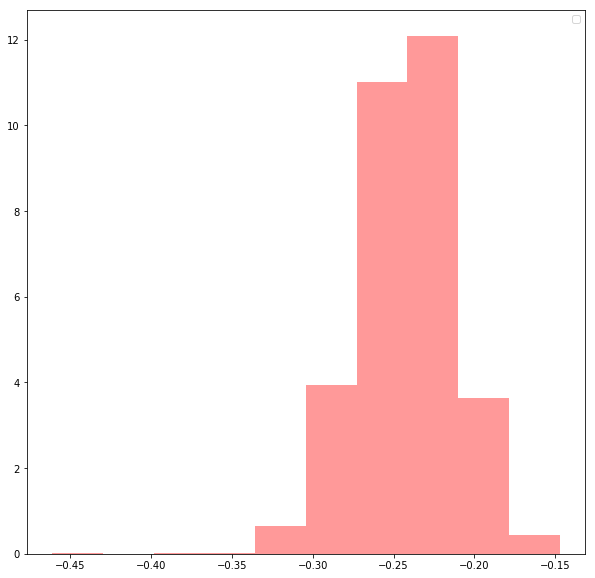

In [337]:
all_lines = [x.split('.')[0] for x in os.listdir('../data/expr/.')]

resp, gene_activ, path_activ = predict_KO([], all_lines, limit=None, return_activations=True, plot=True)

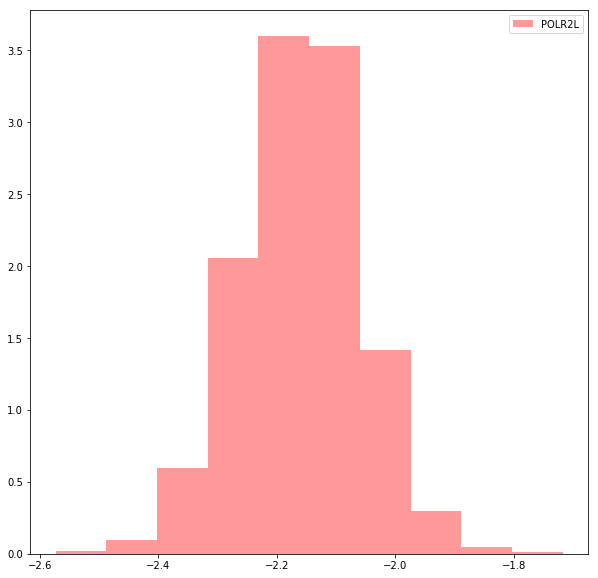

In [396]:
polr2l_resp, polr2l_gene_activ, polr2l_path_activ = predict_KO(['POLR2L'], all_lines, limit=None, return_activations=True, plot=True)

In [385]:
df = pd.DataFrame({line:activ for line,activ in zip(all_lines, path_activ)}).assign(pathway = GO_order_ls).melt(id_vars = ['pathway'], var_name='cell_line', value_name='noKO_resp')
df2 = pd.DataFrame({line:activ for line,activ in zip(all_lines, polr2l_path_activ)}).assign(pathway = GO_order_ls).melt(id_vars = ['pathway'], var_name='cell_line', value_name='polr2l_resp')
df = df.merge(df2, on=['cell_line','pathway'], how='inner').melt(id_vars=['pathway','cell_line'],  var_name='KO', value_name='response')
df = df.merge(GO[['id','name']], left_on='pathway', right_on='id', how='left')
df = df.assign(log2_resp = np.log10(df.response))
df.head()

C:\anaconda-3.5.2.0\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pathway,cell_line,KO,response,id,name,log2_resp
0,GO:0019221,ACH-000001,noKO_resp,1.723239,GO:0019221,cytokine-mediated signaling pathway,0.236346
1,GO:0019221,ACH-000001,noKO_resp,1.723239,GO:0019221,cytokine-mediated signaling pathway,0.236346
2,GO:0019221,ACH-000001,noKO_resp,1.723239,GO:0019221,cytokine-mediated signaling pathway,0.236346
3,GO:0019221,ACH-000001,noKO_resp,1.723239,GO:0019221,cytokine-mediated signaling pathway,0.236346
4,GO:0019221,ACH-000001,noKO_resp,1.723239,GO:0019221,cytokine-mediated signaling pathway,0.236346


C:\anaconda-3.5.2.0\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


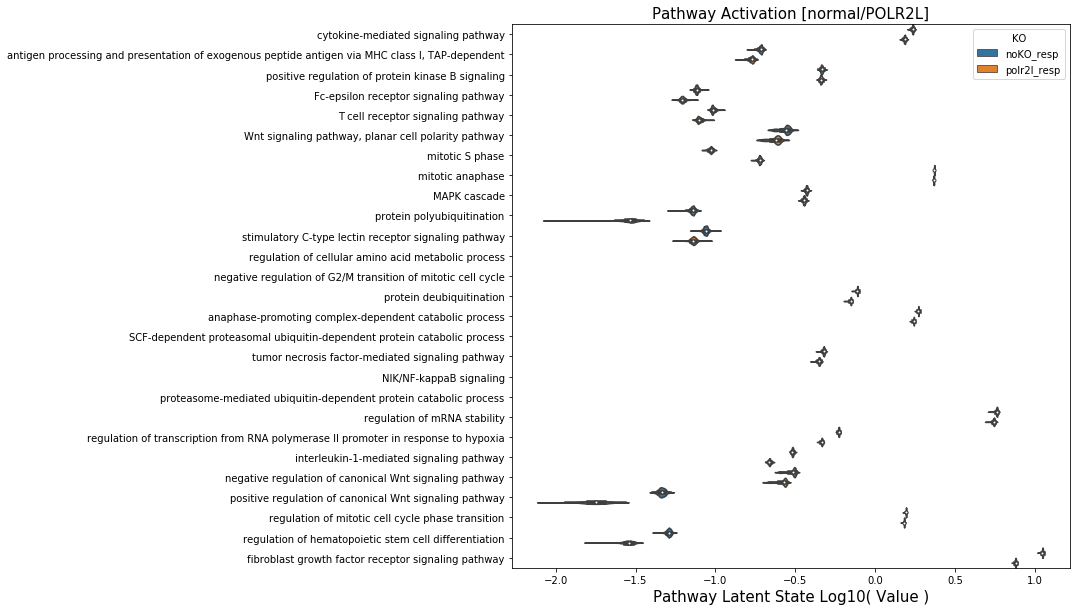

In [387]:
plt.figure(figsize=(10,10))
sbn.violinplot(y='name', x='log2_resp', hue='KO', split=False, width=1, data=df)
plt.title('Pathway Activation [normal/POLR2L]', fontsize=15)
plt.ylabel('')
plt.xlabel('Pathway Latent State Log10( Value )', fontsize=15)
plt.show()

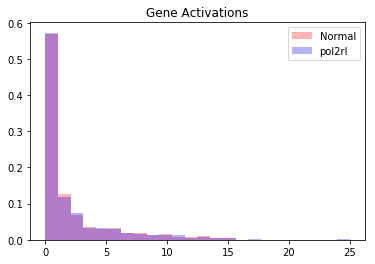

In [412]:
plt.figure()
_bins = np.linspace(0,25,25)
plt.hist(gene_activ[0].ravel(), color='r', density=True, label='Normal', alpha=0.3, bins=_bins)
plt.hist(polr2l_gene_activ[0].ravel(), color='b', density=True, label='pol2rl', alpha=0.3, bins=_bins)
plt.title('Gene Activations')
plt.legend()
plt.show()

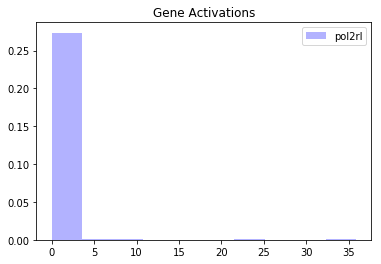

In [432]:
plt.figure()
_bins = None #np.linspace(0,25,25)
plt.hist(np.abs(polr2l_gene_activ[0].ravel()- gene_activ[0].ravel()), color='b', density=True, label='pol2rl', alpha=0.3, bins=_bins)
plt.title('Gene Activations')
plt.legend()
plt.show()

In [475]:

_bins = None #np.linspace(0,25,25)
diff_activ_ = np.abs( polr2l_gene_activ[0].ravel()- gene_activ[0].ravel() )  #> 2
gene_order_ls = [rev_order[i] for i in range(len(rev_order))]
diff_labels = np.array(gene_order_ls)[ diff_activ_ > 15 ]
print(diff_labels)
diff_labels = {gene_order[g]:g for g in diff_labels}
#print(gene_order_ls) 
print(len(diff_activ_))
#activ_color_ = diff_activ_.copy()
#activ_color_[diff_activ_] = 'r'
#activ_color_[~diff_activ_] = 'k'


['POLR2C' 'POLR2I' 'GTF2F2' 'POLR2G' 'HNRNPM' 'NANOG' 'POLR2B' 'POLR2D'
 'POLR2J']
1076


In [476]:
fibro_labels = [gene_order[g] for g in fibro_genes]

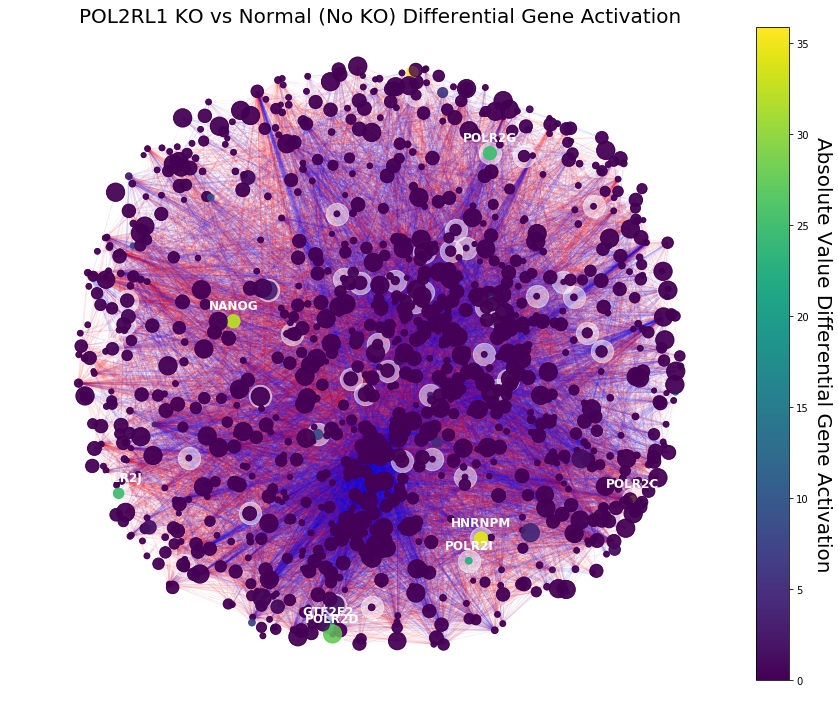

In [483]:
f, ax = plt.subplots(1,1,figsize=(15,12))
_cmap = 'RdYlBu'

_pos2 = {}
y_off = .05  # offset on the y axis

for k, v in _pos.items():
    _pos2[k] = (v[0], v[1]+y_off)
    
#nx.draw_networkx_labels(G, _pos, labels=rev_order, ax=ax)
#nx.draw_networkx_nodes(G, pos=_pos, node_size=100, node_color=np.diag(AC), cmap=_cmap, ax=ax)
#nx.draw_networkx_edges(G, pos=_pos, width=np.array(edge_color_), edge_color=edge_color_, alpha=0.5, edge_cmap=_cmap, ax=ax)

nx.draw_networkx_nodes(G, pos=_pos, nodelist=fibro_labels, node_size=500, alpha=0.5, node_color='w', ax=ax)
nx.draw_networkx_nodes(G, pos=_pos, node_size=100*np.array(node_size_), node_color=diff_activ_, alpha=0.75, ax=ax)
nx.draw_networkx_edges(G, pos=_pos, width=10*alpha_, edge_color=edge_color_, alpha=0.1, ax=ax, cmap=_cmap)
nx.draw_networkx_nodes(G, pos=_pos, node_size=100*np.array(node_size_), node_color=diff_activ_, alpha=0.75, ax=ax)
nx.draw_networkx_labels(G, pos=_pos2, labels=diff_labels, font_color='w', alpha=1, ax=ax, font_weight='bold')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=np.min(diff_activ_), vmax=np.max(diff_activ_)))
sm._A = []
cbar = plt.colorbar(sm, )
cbar.ax.set_ylabel("Absolute Value Differential Gene Activation", rotation=-90, va="bottom", fontsize=20)

plt.gca().axison = False
plt.title('POL2RL1 KO vs Normal (No KO) Differential Gene Activation', fontsize=20)
plt.show()

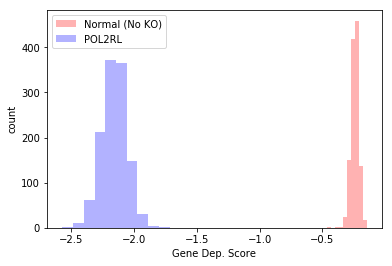

In [391]:
plt.figure()
plt.hist(resp, color='r', alpha=0.3, label='Normal (No KO)')
plt.hist(polr2l_resp, color='b', alpha=0.3,  label='POL2RL')
plt.xlabel('Gene Dep. Score')
plt.ylabel('count')
plt.legend()
plt.show()

In [317]:
map2k2_resp = predict_KO(['MAP2K2'], all_lines)

In [318]:
map2kX_resp = predict_KO(['MAP2K1','MAP2K2'], all_lines) #both

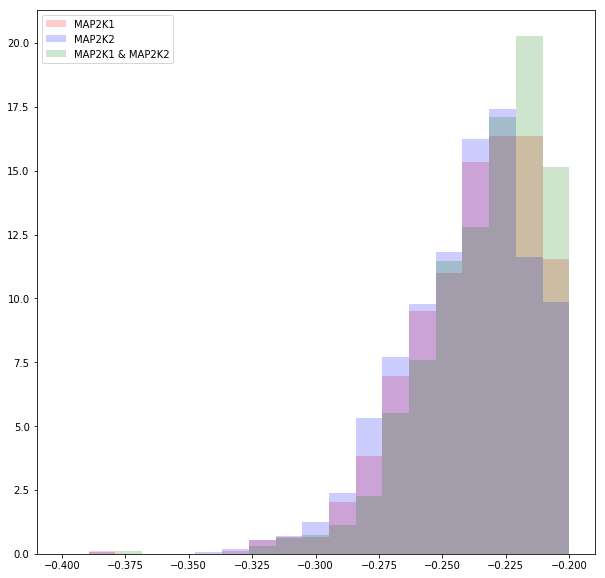

In [327]:
plt.figure(figsize=(10,10))
_bins=np.linspace(-0.4,-0.2,20)
plt.hist(map2k1_resp, color='red', alpha=0.2, density=True, label='MAP2K1', bins=_bins)
plt.hist(map2k2_resp, color='blue', alpha=0.2, density=True, label='MAP2K2', bins=_bins)
plt.hist(map2kX_resp, color='green', alpha=0.2, density=True, label='MAP2K1 & MAP2K2', bins=_bins)
plt.legend()
plt.show()

In [102]:
low_idx = np.array( map2kX_resp ) < -0.4 
low_resp = np.array(map2kX_resp) [ low_idx ] 
low_lines = np.array(all_lines) [ low_idx ]

for resp, line in zip(low_resp, low_lines): 
    print(f'{line} : {resp}')
    
# Depmap ID: ACH-001143 CCLE Name: NKL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE

ACH-001143 : -0.44198185205459595


In [100]:
fibro = GO[GO.name == 'fibroblast growth factor receptor signaling pathway']
fibro_genes = fibro.Gene_Name.unique()
print('GO:0008543 genes: ', fibro_genes)
print('number of genes: ', len(fibro_genes))
fibro.head()

GO:0008543 genes:  ['MAPK3' 'MAPK1' 'GRB2' 'PTPN11' 'FGF23' 'FGF10' 'FGF16' 'FGF17' 'FGF18'
 'FGF19' 'FGF1' 'FGF4' 'FGF2' 'FGF6' 'FGFR1' 'FGF3' 'FGF5' 'FGF7' 'FGFR2'
 'FGFR4' 'FGFR3' 'FGF9' 'FGF8' 'SPRED1' 'KLB' 'FRS2' 'FGF22' 'FGF20' 'KL'
 'NCBP2' 'NCBP1' 'POLR2D' 'POLR2C' 'POLR2E' 'POLR2A' 'POLR2B' 'POLR2I'
 'POLR2H' 'POLR2J' 'POLR2K' 'POLR2F' 'POLR2G' 'POLR2L' 'HNRNPF' 'GTF2F2'
 'GTF2F1' 'CBL' 'HNRNPA1' 'PTBP1' 'HNRNPH1' 'HNRNPM' 'FLRT2' 'RBFOX2'
 'ANOS1' 'TIA1' 'TIAL1' 'GALNT3' 'FGFBP1' 'ESRP1' 'SPRED2' 'FGFRL1'
 'ESRP2' 'FLRT3' 'FLRT1']
number of genes:  64


,Unnamed: 0,id,uniprotKB,name,def,Gene_Name
802,802,GO:0008543,P27361,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ...",MAPK3
803,803,GO:0008543,P27361,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ...",MAPK3
804,804,GO:0008543,P27361,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ...",MAPK3
805,805,GO:0008543,P27361,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ...",MAPK3
1019,1019,GO:0008543,P28482,fibroblast growth factor receptor signaling pa...,"""The series of molecular signals generated as ...",MAPK1


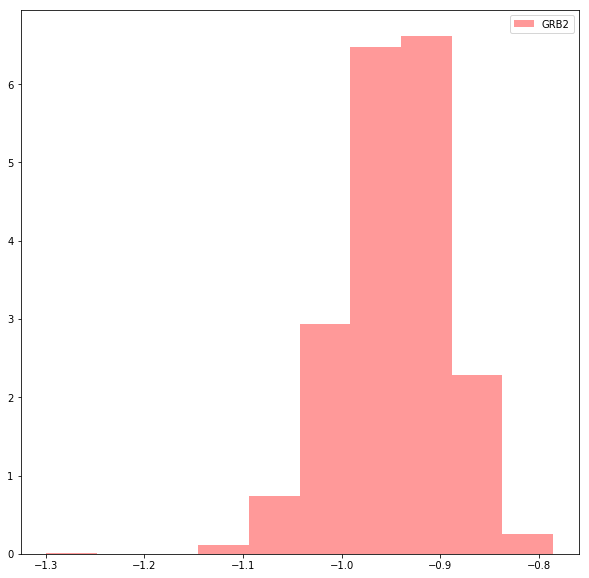

In [109]:
x = predict_KO(['GRB2'], all_lines, plot=True)

In [111]:
low_idx =   np.array( x ) < -1.2 
low_resp =  np.array( x ) [ low_idx ] 
low_lines = np.array( all_lines ) [ low_idx ]

for resp, line in zip(low_resp, low_lines): 
    print(f'{line} : {resp}')
    
# Depmap ID: ACH-001143 CCLE Name: NKL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE

ACH-001143 : -1.30002760887146


# So... it appears that almost all of the variance is based on the `gene KO` and the `cell line` is a +x/-x addition. 

In [113]:
np.corrcoef(x, map2k2_resp)[0,1]

0.9564096016531922

In [114]:
np.corrcoef(x, map2k1_resp)[0,1]

0.9295757851825068

In [115]:
np.corrcoef(x, map2kX_resp)[0,1]

0.9327161448487815

In [133]:
#fibro_resp = []
#for gene in fibro_genes: 
#    x = predict_KO([gene], all_lines, plot=True)
#    fibro_resp.append(x)

In [132]:
# Modified from: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [119]:
with open('../output/fibro_growth_geneKO_preds.pkl', 'wb') as f: 
    pkl.dump(fibro_resp, f)

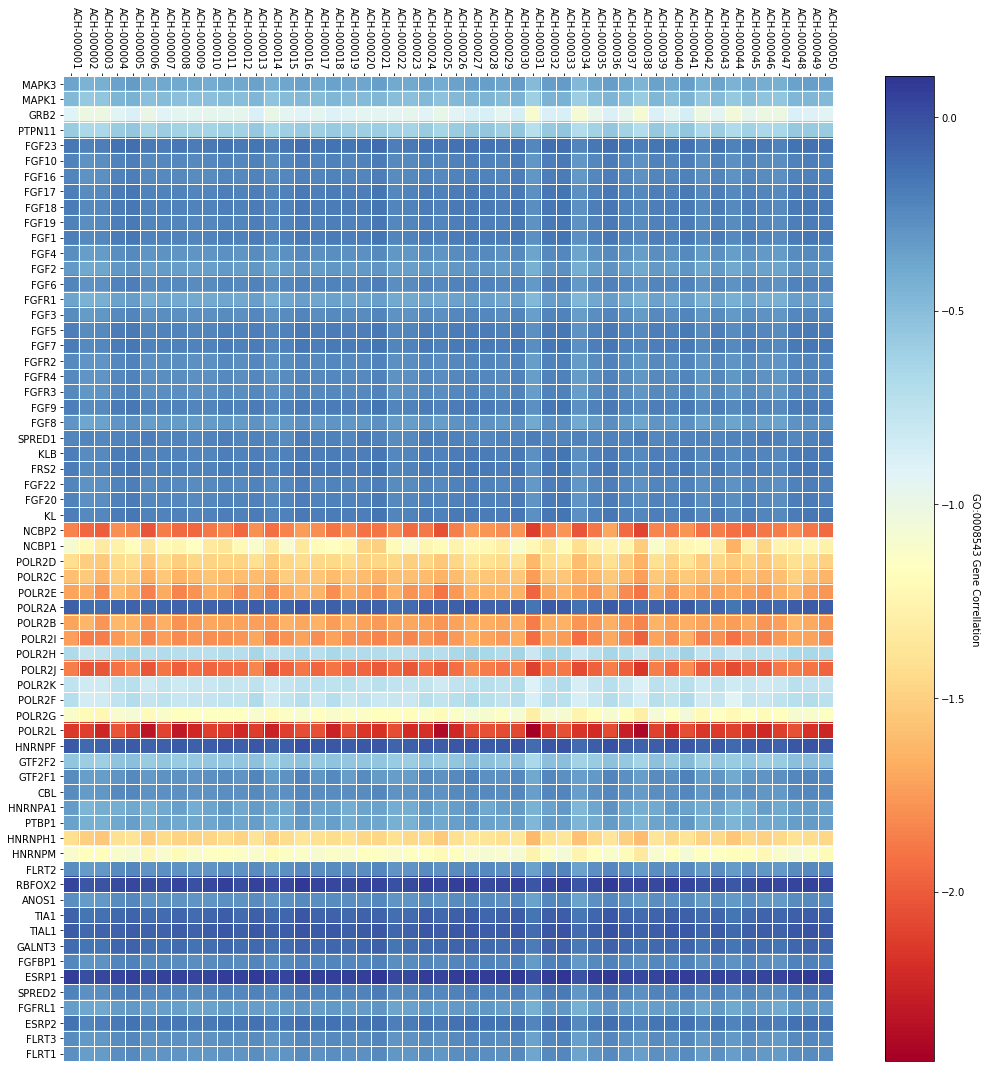

In [158]:
xxx = np.array( [np.array(xx) for xx in fibro_resp] )
coefs = np.corrcoef(xxx)

fig, ax = plt.subplots(1,1,figsize=(15,15))

nlines = 50
heatmap(xxx[:,0:nlines], fibro_genes, all_lines[0:nlines], ax=ax, cmap=plt.cm.RdYlBu, cbarlabel="GO:0008543 Gene Correllation")

fig.tight_layout()
plt.show()

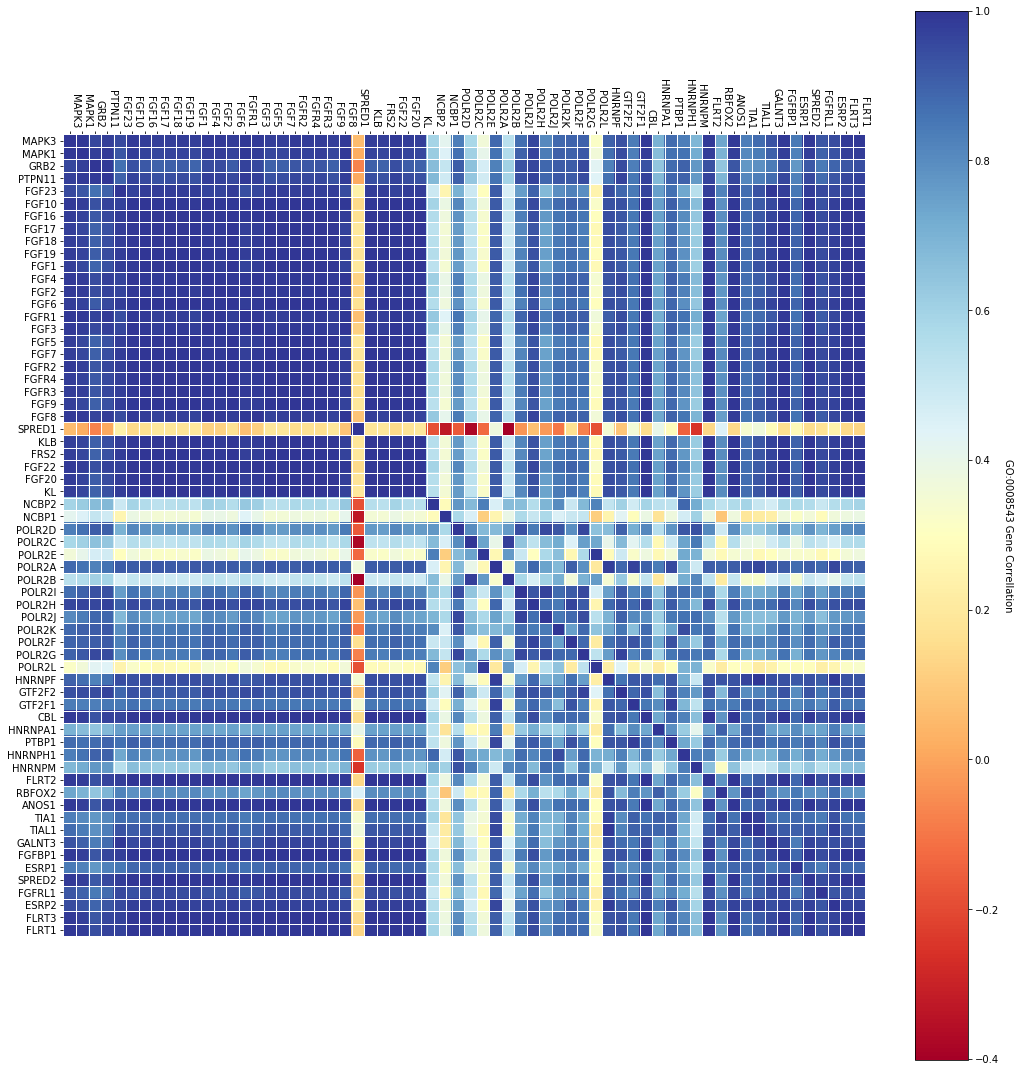

In [134]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

heatmap(coefs, fibro_genes, fibro_genes, ax=ax, cmap=plt.cm.RdYlBu, cbarlabel="GO:0008543 Gene Correllation")

fig.tight_layout()
plt.show()

coef shape: (1210, 1210)


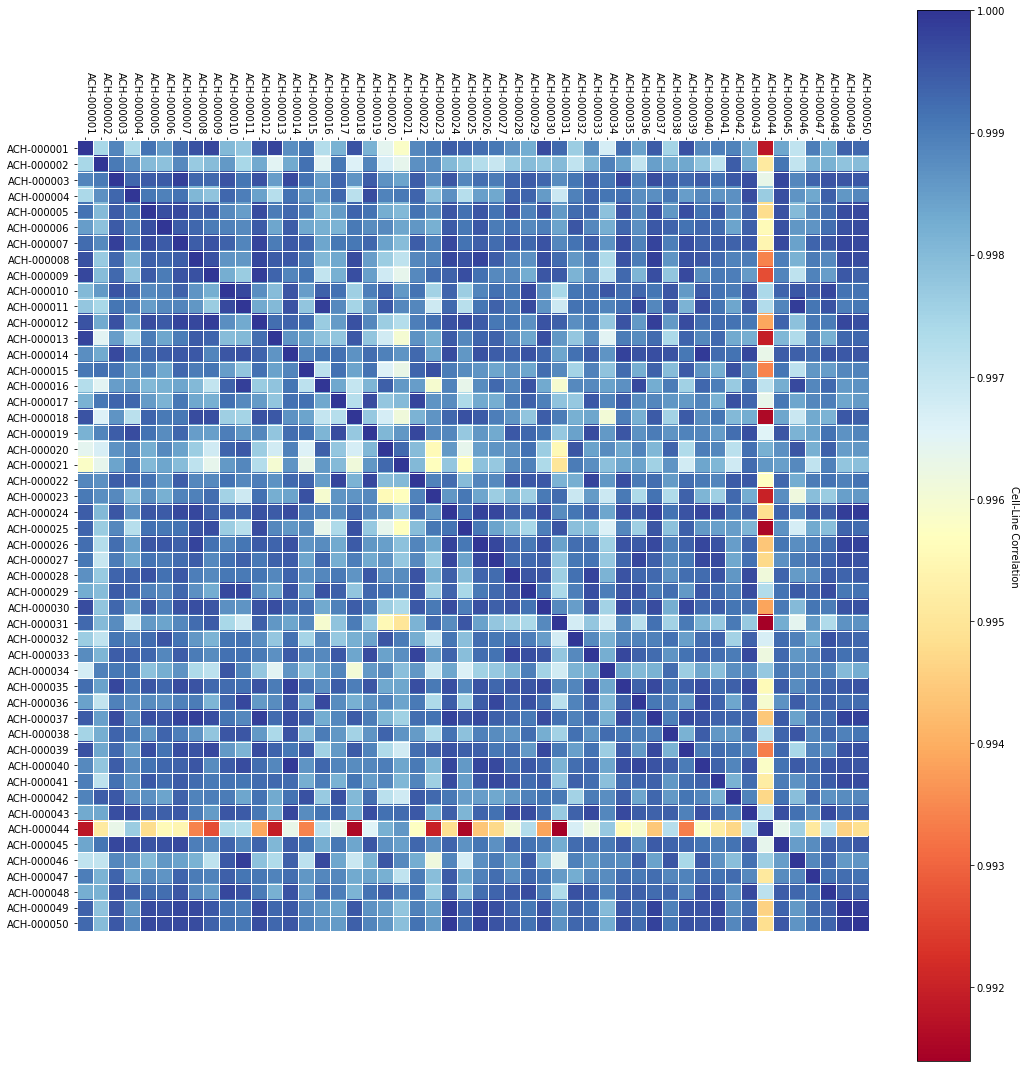

In [163]:
xxx = np.array( [np.array(xx) for xx in fibro_resp] )
coefs = np.corrcoef(xxx.T)
print('coef shape:', coefs.shape)

fig, ax = plt.subplots(1,1,figsize=(15,15))

heatmap(coefs[0:nlines, 0:nlines], all_lines[0:nlines], all_lines[0:nlines], ax=ax, cmap=plt.cm.RdYlBu, cbarlabel="Cell-Line Correlation")

fig.tight_layout()
plt.show()

first line: ACH-000044
first line: ACH-000025
NCBP1


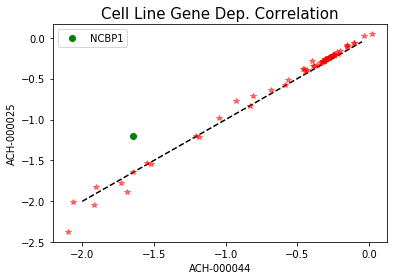

In [313]:
plt.figure()

idx = 43 #np.random.choice(len(fibro_resp)-4)
idy = 24
print('first line:', all_lines[idx])
print('first line:', all_lines[idy])

z = np.arange(-2, 0, 0.05)
plt.plot(z, z, 'k--')

x = xxx[:,idx]
y = xxx[:,idy]
plt.plot(x,y, 'r*', alpha=0.5)
plt.xlabel(all_lines[idx],fontsize=10)
plt.ylabel(all_lines[idy],fontsize=10)
plt.title('Cell Line Gene Dep. Correlation', fontsize=15)

max_diff = 0; max_gene = ''; max_a=0; max_b=0
for g in fibro_genes:
    
    ii = fibro_genes == g
    a = xxx[:,idx][ii]
    b = xxx[:,idy][ii]
    if np.abs(a-b) > max_diff: 
        max_diff = np.abs(a-b)
        max_gene = g
        max_a = a
        max_b = b
    #print(g,a-b,a,b)
    
print(max_gene)    
plt.plot([max_a], [max_b], 'go', label=f'{max_gene}')
plt.legend()
plt.show()

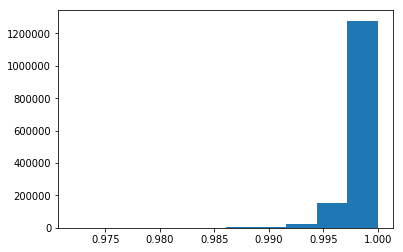

In [206]:
plt.figure()
plt.hist(coefs.flatten())
plt.show()

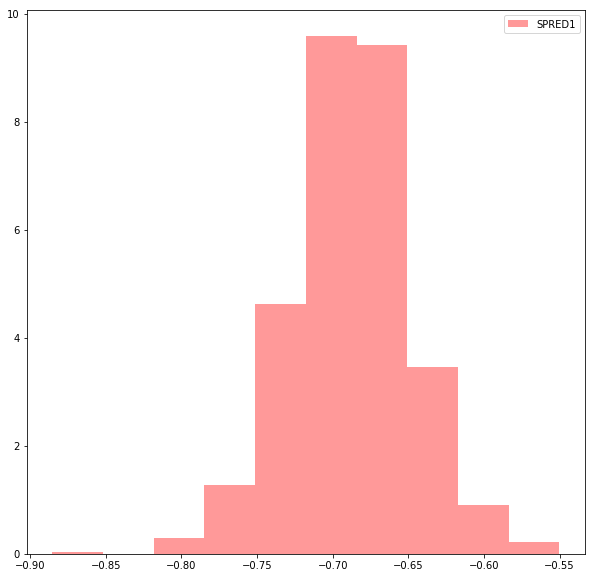

In [137]:
SPRED1 = predict_KO(['SPRED1', 'NCBP2'], all_lines, plot=True)

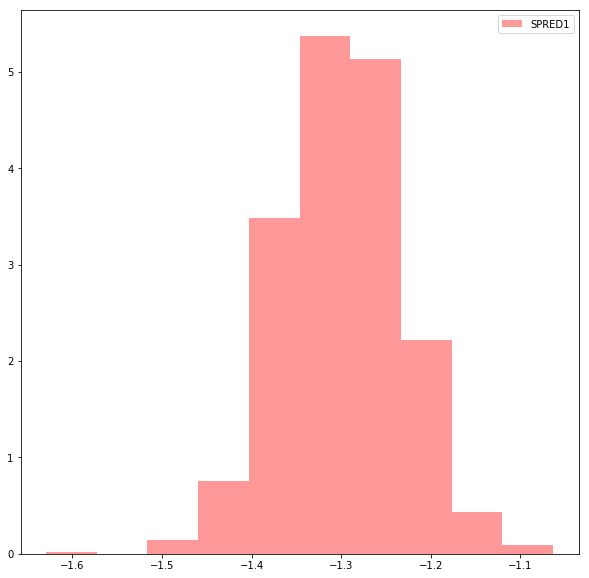

In [138]:
SPRED1 = predict_KO(['SPRED1', 'POLR2E'], all_lines, plot=True)

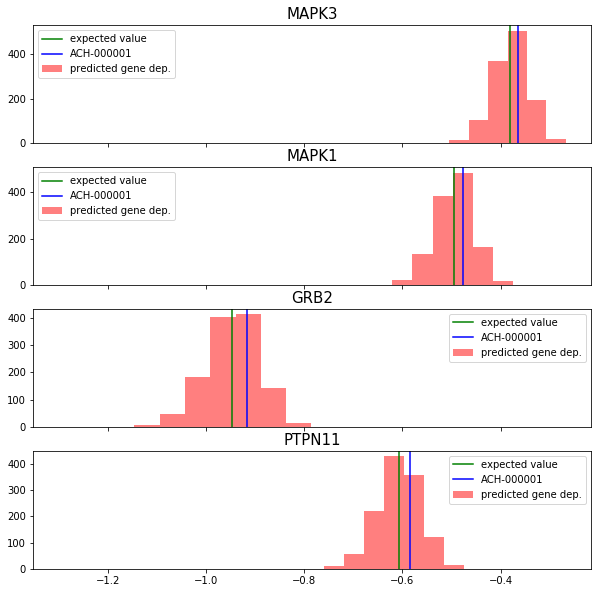

In [155]:
def plotmyhist(x, gene, lines, ax, line_highlight='ACH-000001'): 
    
    ax.hist(x, color='r', alpha=0.5, label='predicted gene dep.')
    ax.axvline(x=np.mean(x), color='g', label='expected value')
    ax.axvline(x=x[lines == line_highlight], color='b', label=line_highlight)
    ax.set_title(gene, fontsize=15)

f, ax = plt.subplots(4,1, figsize=(10,10), sharex=True)

for i in range(4):
    plotmyhist(fibro_resp[i], fibro_genes[i], all_lines, ax[i])
    ax[i].legend()
    
plt.show()
